In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("match.csv", encoding='utf-8')

# Filter only rows where label is "Lexical"
df_lexical = df[df['Label'] == 'Lexical']

# Save the filtered result
df_lexical.to_csv("match_lexical_only.csv", index=False, encoding='utf-8-sig')

print(f"✅ Saved {len(df_lexical)} rows with label = 'Lexical' to match_lexical_only.csv")


✅ Saved 5011 rows with label = 'Lexical' to match_lexical_only.csv


In [4]:
import pandas as pd

# Load your cleaned Bengali dataset
df = pd.read_csv("cleaned_file.csv", encoding="utf-8")

# Add 'Label' column with all values set to "PARTIAL MATCH"
df['Label'] = "PARTIAL MATCH"

# Save the updated file
df.to_csv("clean_file_with_label.csv", index=False, encoding='utf-8-sig')

print("✅ Added 'Label' column with value 'PARTIAL MATCH' to all rows.")


✅ Added 'Label' column with value 'PARTIAL MATCH' to all rows.


In [8]:
import pandas as pd

# Function to normalize and keep only relevant columns
def load_and_standardize(file_path):
    df = pd.read_csv(file_path, encoding="utf-8")
    
    # Normalize column names (lowercase + strip)
    df.columns = [col.strip().lower() for col in df.columns]

    # Map to expected column names
    col_map = {
        'sentence': 'sentence1',         # For clean_file_with_label
        'sentence1': 'sentence1',
        'sentence2': 'sentence2',
        'label': 'Label'
    }
    
    # Rename and filter
    df = df.rename(columns=col_map)
    df = df[['sentence1', 'sentence2', 'Label']]
    
    return df

# Load and clean all datasets
df1 = load_and_standardize("clean_file_with_label.csv")
df2 = load_and_standardize("no_match_pairs.csv")
df3 = load_and_standardize("match_lexical_only.csv")

# Combine
df_merged = pd.concat([df1, df2, df3], ignore_index=True)

# Optional: Shuffle
df_merged = df_merged.sample(frac=1, random_state=42).reset_index(drop=True)

# Save final dataset
df_merged.to_csv("Bangla_Semantic_Dataset.csv", index=False, encoding='utf-8-sig')

print(f"✅ Final dataset created with {len(df_merged)} records in Bangla_Semantic_Dataset.csv")


✅ Final dataset created with 12229 records in Bangla_Semantic_Dataset.csv


C:\Users\Istiak\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.sparse import csr_matrix, issparse


CUDA available: True
Label classes: ['Lexical' 'NO match' 'PARTIAL MATCH']


C:\Users\Istiak\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9783 [00:00<?, ? examples/s]

Map:   0%|          | 0/2446 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.075900,0.012631,0.997956
2,0.011800,0.017357,0.996321
3,0.007400,0.010185,0.998365
4,0.001300,0.010145,0.998365



Classification Report:
               precision    recall  f1-score   support

      Lexical       1.00      1.00      1.00       777
     NO match       1.00      1.00      1.00       803
PARTIAL MATCH       1.00      1.00      1.00       866

     accuracy                           1.00      2446
    macro avg       1.00      1.00      1.00      2446
 weighted avg       1.00      1.00      1.00      2446



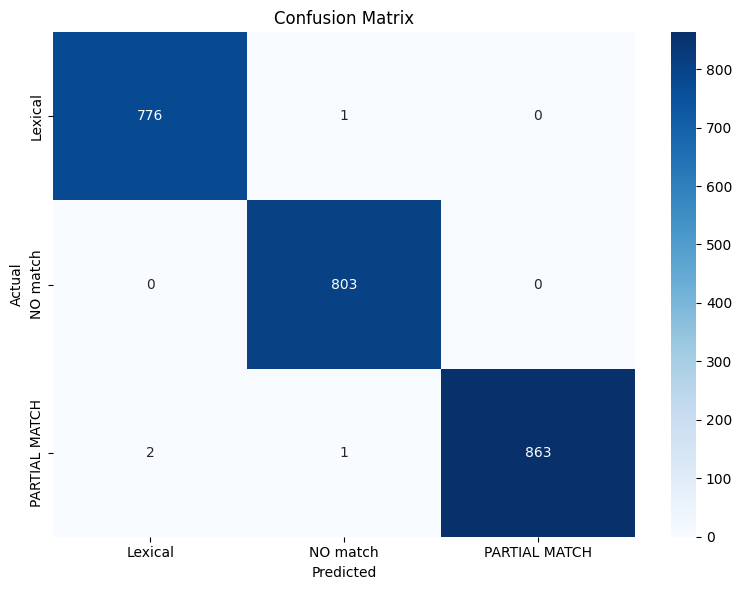

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset

print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("Bangla_Semantic_Dataset.csv", encoding='utf-8')
df = df.dropna(subset=["sentence1", "sentence2", "Label"]).reset_index(drop=True)


label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Label"])  
labels = label_encoder.classes_
print(f"Label classes: {labels}")


df["text"] = df["sentence1"] + "SEP" + df["sentence2"]  # [SEP] helps BERT separate segments


dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
).to(device)


training_args = TrainingArguments(
    output_dir="./results_bangla_semantic",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs_bangla",
    load_best_model_at_end=True,
    save_total_limit=1
)


def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = (preds == p.label_ids).mean()
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


trainer.train()

preds = trainer.predict(dataset["test"])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)


y_prob = torch.nn.functional.softmax(torch.tensor(preds.predictions), dim=1).numpy()


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [40]:
df["Label"]

0              Lexical
1             NO match
2              Lexical
3              Lexical
4             NO match
             ...      
12224          Lexical
12225         NO match
12226         NO match
12227    PARTIAL MATCH
12228         NO match
Name: Label, Length: 12229, dtype: object

Label classes: ['Lexical' 'NO match' 'PARTIAL MATCH']


C:\Users\Istiak\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9783 [00:00<?, ? examples/s]

Map:   0%|          | 0/2446 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000800,0.032876,0.993868
2,0.000200,0.017628,0.996321
3,0.000100,0.014528,0.996729



📊 Classification Report:
               precision    recall  f1-score   support

      Lexical       1.00      1.00      1.00       820
     NO match       1.00      1.00      1.00       800
PARTIAL MATCH       1.00      1.00      1.00       826

     accuracy                           1.00      2446
    macro avg       1.00      1.00      1.00      2446
 weighted avg       1.00      1.00      1.00      2446



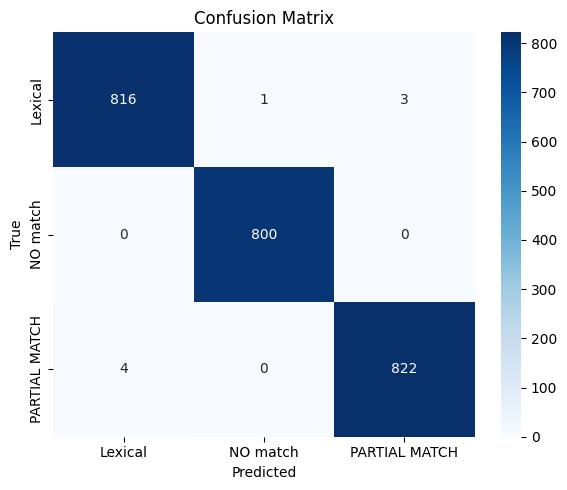

In [41]:

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Label"])  # e.g., 0, 1, 2
labels = label_encoder.classes_
print(f"Label classes: {labels}")


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"],
                     truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels)).to(device)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_dir='./logs',
    logging_steps=10,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


def compute_metrics(eval_pred):
    predictions, labels_true = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = (preds == labels_true).mean()
    return {"accuracy": acc}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer.train()


preds_output = trainer.predict(test_dataset)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)


print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [65]:

def predict_relationship(sentence1, sentence2):
    model.eval()  # Set model to evaluation mode
    inputs = tokenizer(
        sentence1,
        sentence2,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label


In [66]:
s1 = "সে ক্রিকেট খেলে।"
s2 = "সে ফুটবল খেলে।"
print(f"Prediction: {predict_relationship(s1, s2)}")   #New Data From chatgpt 


Prediction: PARTIAL MATCH


In [69]:
s1 = "প্রতিদিন বিকালে পত্রিকা পড়া হয় তার দ্বারা।"
s2 = "সে প্রতিদিন বিকালে পত্রিকা পড়ে।"
print(f"Prediction: {predict_relationship(s1, s2)}")  #From Dataset

Prediction: Lexical


In [70]:
s1 = "হাব ব্যবহার করছিলাম।।"
s2 = "এখনোও সবুজ স্কুল হইতে ফিরে নাই"
print(f"Prediction: {predict_relationship(s1, s2)}")     #From Dataset

Prediction: NO match


In [72]:
s1 = "বাচ্চারা মাঠে খেলছে।"
s2 = "কিছু বাচ্চা মাঠে খেলছে ।"
print(f"Prediction: {predict_relationship(s1, s2)}")        #New Data From chatgpt 

Prediction: Lexical


In [73]:
s1 = "আজ রোদ ছিল খুব বেশি।"
s2 = "আজকের আবহাওয়া ছিল গরম।"
print(f"Prediction: {predict_relationship(s1, s2)}")    #New Data From chatgpt 

Prediction: PARTIAL MATCH


In [76]:
s1 = "সে প্রতিদিন সকালে চা পান করে, তারপর অফিসের কাজ শুরু করে।"
s2 = "প্রতিদিন সকালে চা খাওয়ার পরে সে অফিসে যাওয়ার জন্য প্রস্তুতি নেয়।"
print(f"Prediction: {predict_relationship(s1, s2)}")  #  New Data From chatgpt 

Prediction: Lexical


In [77]:
s1 = "গণনা করিয়া থাকব।"
s2 = "তিনি তার পুরো পরিবারকেই এই শিক্ষা দিয়েছিলেন"
print(f"Prediction: {predict_relationship(s1, s2)}")  #  New Data From chatgpt 

Prediction: NO match


In [78]:
s1 = "সে রাতে ঘুমানোর আগে বই পড়ে, যা তার জ্ঞান বাড়াতে সাহায্য করে।"
s2 = "রাতে ঘুমানোর আগে সে বই পড়ে, যাতে তার পড়াশোনায় উন্নতি হয়।"
print(f"Prediction: {predict_relationship(s1, s2)}")  #  New Data From chatgpt

Prediction: Lexical


In [80]:

s1 = "সে সকালে দেরি করে ঘুম থেকে উঠেছে।"
s2 = "সে আজ সকালেই উঠেছিল, কিন্তু দেরি করে বাড়ি থেকে বেরিয়েছে।"
print(f"Prediction: {predict_relationship(s1, s2)}")  #  New Data From chatgpt

Prediction: Lexical


In [85]:
s1 = "সে ভবিষ্যতে একটি নতুন চাকরি শুরু করবে।"
s2 = "সে ভবিষ্যতে একটি নতুন চাকরি শুরু করবে।"
print(f"Prediction: {predict_relationship(s1, s2)}")


Prediction: Lexical


In [86]:
s1 = "সে ভবিষ্যতে একটি নতুন চাকরি শুরু করবে।"
s2 = "সে ভবিষ্যতে একটি নতুন ব্যবসা শুরু করবে"
print(f"Prediction: {predict_relationship(s1, s2)}")

Prediction: PARTIAL MATCH
